Wahlpflichtfach Künstliche Intelligenz II: Praktikum 

---

# 02 - Neuronale Netze mit Tensorflow

Nachdem wir uns gerade angeguckt haben, was Tensorflow grundlegen ist und das Arbeiten mit Daten aufgefrischt haben, wollen wir uns als Nächstes den Grundlagen der Neuronalen Netze widmen.

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [31]:
%matplotlib inline

In [6]:
print(tf.__version__)

2.14.0


## Neuronen und Layer

Zuerst schauen wir uns dabei ein Neuron sowie den Aufbau eines Layers an. Wobei ein Layer aus einen, bis mehreren Neuronen besteht.
Ein Neuron besteht dabei aus drei Funktionen:
* Übertragungsfunktion: Summe alle gewichteten Inputs addiert um den Bias-Wert
* Aktivierungsfunktion: z. B. ReLU
* Ausgabefunktion: Ausgabe Funktion in der Regel Identität

### lineare Layer
Jedes neuronale Netz besteht aus mehreren Schichten. Die Schichten sind also die Bausteine. 
Unsere erste Layer ist eine lineare Layer, die nur den Drive berechntet. Wir verwenden hier keine Aktivierungsfunktion.

Um eine Layer zu definieren, brauchen wir eine Klasse, die von `tf.keras.layers.Layer` erbt.
Zusätzlich enthält TensorFlow 2 bereits viele eingebaute Schichten, die Ihr hier finden könnt: https://www.tensorflow.org/api_docs/python/tf/keras/layers.

In [4]:
from keras.layers import Layer

class Linear(Layer):
    
    def __init__(self, units):
        super(Linear, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        self.w = self.add_weight(
                        shape=(input_shape[-1], self.units),
                        initializer=tf.random_normal_initializer(),
                        trainable=True
        )
        self.b = self.add_weight(
                        shape=(self.units,),
                        initializer=tf.random_normal_initializer(),
                        trainable=True
        )
     
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

Test des linearen Layers

In [5]:
linear_layer = Linear(4)

x = tf.ones((1,4))
y = linear_layer(x)

print(x)
print(y)

tf.Tensor([[1. 1. 1. 1.]], shape=(1, 4), dtype=float32)
tf.Tensor([[ 0.0436712   0.09128283  0.00701033 -0.04689809]], shape=(1, 4), dtype=float32)


2024-01-07 15:10:34.351454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 15:10:34.351641: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Mehrere Layer verbinden
Um mehrere Layer miteinander zu verknüpfen, können wir diese in einer neuen Klasse, die wiederum ein Layer ist kombinieren.
Dabei sprechen wir von einem Dens Layer, wenn alle Neuronen aus der vorherigen Layer mit allen Neuronen des aktuellen Layers verknüpft sind.

Arten von Layern
* Input: Erste schicht im Netz
* Hidden: Zwischen schichten im Netz
* Output: Ausgabe Schicht im Netz

Hier findet ihr eine anschauliche [Visualisierung](https://playground.tensorflow.org) des Prinzipes.

In [6]:
class MLP(Layer):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_layer = Linear(512)
        self.output_layer = Linear(1)
        
    def call(self, x):
        x = self.hidden_layer(x)
        x = tf.nn.relu(x)
        x = self.output_layer(x)
        return x

### Training des neuronalen Netzes
Um das neuronale Netz zu trainieren, müssen wir zuerst noch die Loss-Funktion ([Dokumentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses)) und den Optimierer ([Dokumentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)) bestimmen.

In [7]:
tf.keras.backend.clear_session()

mlp = MLP()

mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

Zum Training verwenden wir den Datensatz aus dem ersten Kapitel

In [8]:
def f(x):
    return 0.002*(x**3-x**2+2*x)+0.3

xs = np.linspace(-5,5, 20, dtype=np.float32)
ys = f(xs)

ids = np.arange(len(xs))
training_data_ids = np.random.choice(ids,15, replace=False)
test_data_ids = ~np.isin(ids, training_data_ids)
training_data_xs = xs[training_data_ids]
training_data_ys = ys[training_data_ids]
test_data_xs = xs[test_data_ids]
test_data_ys = ys[test_data_ids]

train_dataset = tf.data.Dataset.from_tensor_slices((training_data_xs, training_data_ys)).batch(15)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_xs, test_data_ys)).batch(5)

Dann müssen wir nur noch unsere Trainingsschleife bauen.

In [9]:
train_losses = []
test_losses = []
epochs = []

for epoch in range(1000):
    epochs.append(epoch)
    
    for (x,y) in train_dataset:
        
        x = tf.reshape(x, shape=(-1,1))

        with tf.GradientTape() as tape:
            output = mlp(x)
            loss = mse(y, output)
            train_losses.append(loss)
            gradients = tape.gradient(loss, mlp.trainable_variables)

        optimizer.apply_gradients(zip(gradients, mlp.trainable_variables))        

    for (x,y) in test_dataset:
        x = tf.reshape(x, shape=(-1,1))
        output = mlp(x)
        loss = mse(y, output)       
        test_losses.append(loss)

Anschließend können wir mit unseren gesammelten Werten den Traingsprozess visualisieren.

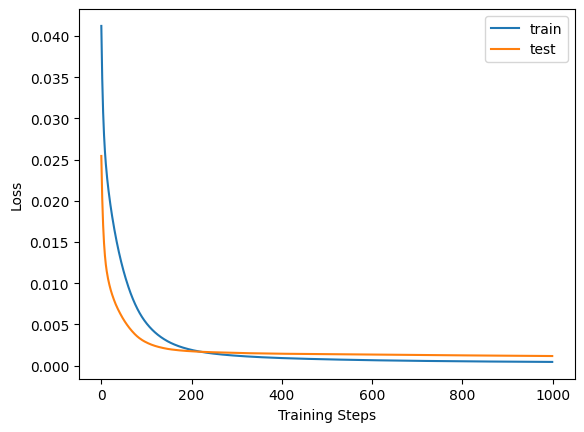

In [10]:
plt.figure()
plt.plot(epochs, train_losses)
plt.plot(epochs, np.array(test_losses))
plt.legend(("train","test"))
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()

Und zum Schluss können wir auch noch die Approximation visualisieren. 

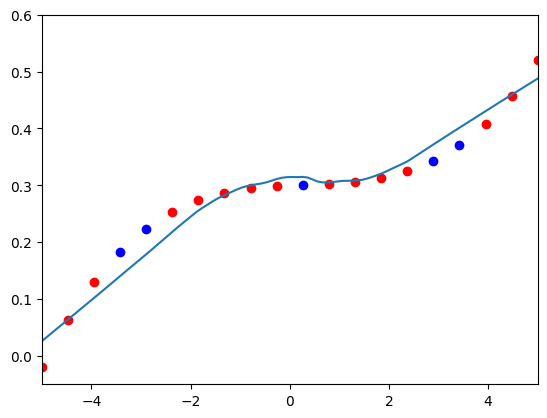

In [11]:
plt.figure()
plt.scatter(training_data_xs, training_data_ys, c='red')
plt.scatter(test_data_xs, test_data_ys, c='blue')

xs = np.linspace(-5,5,100, dtype=np.float32)
xs = np.reshape(xs, newshape=(-1,1))
ys = mlp(xs)

plt.plot(xs,ys)
plt.xlim(-5,5)
plt.ylim(-0.05,0.6)
plt.show()

## Multilayer perceptron (MLP)

### Aktivierungsfunktionen
Wie erwähnt gibt es verschiedene Aktivierungsfunktionen. Diese kommen je nach Aufgabe oder Layer zum Einsatz:
- Layer
  - Hidden: Bei MLPs kommt in der Regel die im Hidden Layer eine ReLU zum Einsatz (es können aber auch andere verwandte Funktionen versucht werden wie: Leaky ReLU / Parametric ReLU, ELU oder SeLU)
  - Output: 
    - Regression: Hier wird häufig eine lineare Funktion bzw die Identität verwendet 
    - Classification:
      - Binary oder Multi-Label Classification: Also Funktion sollte im Output Sigmoid verwendet werden
      - Multi-Class Classification: Also Funktion sollte im Output Softmax verwendet werden

Zusätzlich sollte erwähnt werden das es noch die TanH Funktion gibt. Zum nachlesen findet ihr [hier](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/) mehr.


In der nächsten Zelle erstellen wir das neuronale Netz. Dafür verwenden wir ein [sequentielles Modell](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential?hl=en). Diese hilft dabei ein Modell aus einer Liste von Layern zu erstellen und die Layer zu trainieren. Als Layer nehmen wir das [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?hl=en)-Layer.

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

iris = datasets.load_iris()
y = to_categorical(iris.target)

x_train, x_test, y_train, y_test = train_test_split(iris.data, y, test_size=0.3, random_state=42)

2024-01-07 15:33:25.792213: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 15:33:25.793373: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 15:33:25.811651: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 15:33:25.811674: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 15:33:25.811689: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [23]:
from keras import Sequential
from keras.layers import Dense

model = Sequential(name="classification_mlp")
model.add(Dense(8, activation='relu', input_dim=4))
model.add(Dense(3, activation='softmax'))

Im Folgenden wir gezeigt, wie wir die Struktur unseres neuronalen Netzes ausgeben lassen können.

In [24]:
model.summary()

Model: "classification_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 40        
                                                                 
 dense_5 (Dense)             (None, 3)                 27        
                                                                 
Total params: 67 (268.00 Byte)
Trainable params: 67 (268.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


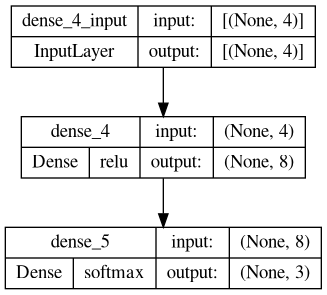

In [25]:
from keras import utils

utils.plot_model(
    model, 
    show_shapes=True, 
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True
)

## Loss, Optimizer und Metriken

Folgend sind die Dokumentationen für die Loss-Funktionen, Optimiere und Metriken verlinkt. Als kleine Empfehlung könnt ihr meistens gut auf adaptiven Optimierer zurückgreifen wie `Adam`.
* [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
* [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
* [Metriken](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [26]:
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import (
    CategoricalAccuracy,
    Recall,
    Precision,
)


model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=CategoricalCrossentropy(),
    metrics=[
        CategoricalAccuracy(),
        Recall(),
        Precision(),
    ]
)

## Einrichten von TensorBoard
Um die Visualisierung des Trainings zu automatisieren, kann [TensorBoard](https://www.tensorflow.org/tensorboard) verwendet werden. Dieses hilft dabei den Trainingsfortschritt zu visualisieren. Um TensorBoard im Training zu aktivieren müssen wir uns eine callback-Funktion erstellen ([Doku](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard?hl=en)). 

In [27]:
from datetime import datetime
from keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(
    log_dir=f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}", 
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
)

## Trainieren des neuronalen Netzes
Für das Training müssen wir nicht unbedingt eine Trainingschleife schreiben. Stattdessen können wir auch die `fit()`-Methode des `Sequential`-Modells verwenden.

In [28]:
model.fit(
    x=x_train, 
    y=y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=25,
    callbacks=[tensorboard_callback]
)

Epoch 1/15


4/4 [==============================] - 0s 43ms/step - loss: 1.8681 - categorical_accuracy: 0.2143 - recall_4: 0.1905 - precision_4: 0.2500 - val_loss: 1.0175 - val_categorical_accuracy: 0.4762 - val_recall_4: 0.4762 - val_precision_4: 0.5000
Epoch 2/15
4/4 [==============================] - 0s 13ms/step - loss: 1.0766 - categorical_accuracy: 0.4286 - recall_4: 0.2024 - precision_4: 0.3778 - val_loss: 1.0154 - val_categorical_accuracy: 0.4286 - val_recall_4: 0.3333 - val_precision_4: 0.4118
Epoch 3/15
4/4 [==============================] - 0s 12ms/step - loss: 0.9089 - categorical_accuracy: 0.6310 - recall_4: 0.1429 - precision_4: 0.3750 - val_loss: 0.8115 - val_categorical_accuracy: 0.7619 - val_recall_4: 0.0952 - val_precision_4: 1.0000
Epoch 4/15
4/4 [==============================] - 0s 12ms/step - loss: 0.7678 - categorical_accuracy: 0.6905 - recall_4: 0.4643 - precision_4: 0.7959 - val_loss: 0.6788 - val_categorical_accuracy: 0.6667 - val_recall_4: 0.6667 - val_precision_4: 0.6667

## Evaluation

In [29]:
loss, acc, rec, prec = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 0.3001 - categorical_accuracy: 0.9778 - recall_4: 0.9778 - precision_4: 0.9778


In [ ]:
%load_ext tensorboard
%tensorboard --host 127.0.0.1 --port=8080 --logdir logs/fit

In [40]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)

y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test_classes, y_pred_classes))

2/2 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      1.00      0.96        13
           2       1.00      0.92      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45



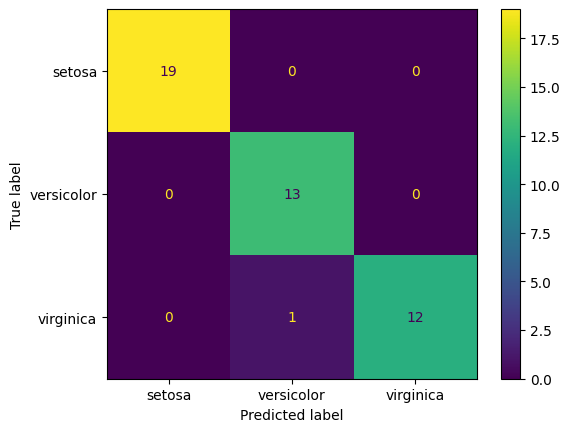

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test_classes, y_pred_classes, display_labels=iris.target_names)

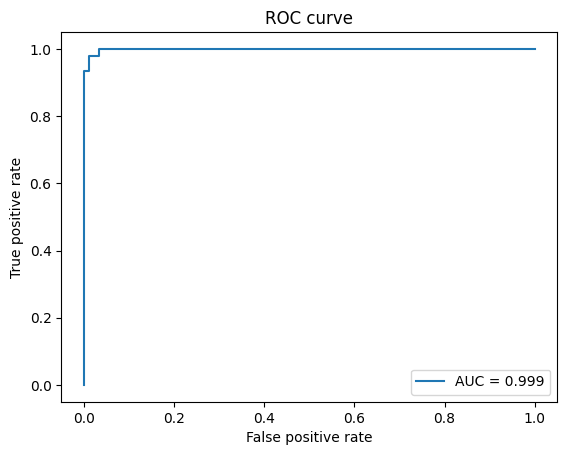

In [51]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()

---

Wahlpflichtach Künstliche Intelligenz II: Praktikum 